<a href="https://colab.research.google.com/github/Joyuri1022/Cloud_Network_Group2/blob/main/model_comparison_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import os
from typing import Dict, Any, List, Tuple
from huggingface_hub import login
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import userdata

from tqdm import tqdm
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    AutoModelForCausalLM,
    AutoTokenizer,
)
HF_TOKEN = userdata.get("HF_TOKEN")
login(token=HF_TOKEN)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_COSINE = True
DEFAULT_THRESHOLD = 0.8

OUTPUT_DIR = "./outputs_networks"
os.makedirs(OUTPUT_DIR, exist_ok=True)

CORPUS: List[str] = [
    # ===== 10 Controversial Binary Prompts =====
    "Is the Earth flat?",
    "Did humans really land on the Moon?",
    "Do vaccines cause autism?",
    "Is climate change primarily caused by human activity?",
    "Do humans use only 10 percent of their brain?",
    "Is astrology scientifically valid?",
    "Are goldfish limited to a three-second memory?",
    "Is MSG harmful to human health?",
    "Are bats completely blind?",
    "Does detoxing with juice cleanse the body effectively?",

    # ===== 1. Descriptive (10-11) =====
    "A quiet river winds through the valley beneath snowy mountains.",
    "The old wooden cabin stood alone under the bright morning sun.",

    # ===== 2. Scientific / Expository (12-13) =====
    "Quantum entanglement describes a correlation between particles that persists over long distances.",
    "Photosynthesis converts light energy into chemical energy inside plant cells.",

    # ===== 3. Narrative / Story (14-15) =====
    "After the storm passed, the villagers gathered to rebuild their damaged homes.",
    "She opened the ancient book and felt a strange warmth radiating from its pages.",

    # ===== 4. Reasoning / Logical (16-17) =====
    "If all mammals are warm-blooded and whales are mammals, then whales must be warm-blooded.",
    "If a number is divisible by both 2 and 3, then it must be divisible by 6.",

    # ===== 5. Instructional / Question (18-19) =====
    "Explain the main differences between renewable and nonrenewable energy sources.",
    "How does photosynthesis contribute to the global carbon cycle?",

    # ===== 6. Emotional / Expressive (20-21) =====
    "I felt overwhelming relief when I finally received the good news.",
    "The film left me heartbroken but strangely hopeful at the same time.",

    # ===== 7. Conversational / Casual (22-23) =====
    "Hey, are you free later this afternoon?",
    "I'm thinking of buying a new laptop—any suggestions?",

    # ===== 8. List-like / Enumeration (24-25) =====
    "apples, bananas, grapes, oranges, strawberries",
    "iron, copper, silver, gold, platinum",

    # ===== 9. Technical / Domain-specific (26-27) =====
    "The algorithm converges when the gradient norm falls below the predefined threshold.",
    "The central bank raised interest rates to control inflationary pressure.",

    # ===== 10. Nonsense / Semantically Odd (28-29) =====
    "Colorless green ideas sleep furiously.",
    "The purple cloud whispered quietly to the dancing calculator.",
]



MODEL_SPECS = [
    {
        "id": "gpt2",
        "hf_name": "gpt2",
        "model_class": GPT2LMHeadModel,
        "tokenizer_class": GPT2Tokenizer,
        "max_length": 40,
        "trust_remote_code": False,
    },
    {
        "id": "qwen1_5",
        "hf_name": "Qwen/Qwen1.5-0.5B",
        "model_class": AutoModelForCausalLM,
        "tokenizer_class": AutoTokenizer,
        "max_length": 40,
        "trust_remote_code": True,
    },
    {
        "id": "qwen2_5",
        "hf_name": "Qwen/Qwen2.5-0.5B",
        "model_class": AutoModelForCausalLM,
        "tokenizer_class": AutoTokenizer,
        "max_length": 40,
        "trust_remote_code": True,
    },
    {
        "id": "qwen3",
        "hf_name": "Qwen/Qwen3-0.6B-base",
        "model_class": AutoModelForCausalLM,
        "tokenizer_class": AutoTokenizer,
        "max_length": 40,
        "trust_remote_code": True,
    },
]


def load_model(
    spec: Dict[str, Any],
    device: str = DEVICE,
):
    print(f"Loading model: {spec['hf_name']} on {device}...")
    tokenizer = spec["tokenizer_class"].from_pretrained(
        spec["hf_name"],
        trust_remote_code=spec.get("trust_remote_code", False),
    )
    model = spec["model_class"].from_pretrained(
        spec["hf_name"],
        output_hidden_states=True,
        trust_remote_code=spec.get("trust_remote_code", False),
    ).to(device)
    model.eval()
    return model, tokenizer

def get_model(model_id: str):
    spec = next(s for s in MODEL_SPECS if s["id"] == model_id)
    model, tokenizer = load_model(spec)
    return model, tokenizer, spec


In [17]:
# Core utilities (hidden states, similarity, graph, visualization)

def extract_hidden_states(
    model,
    tokenizer,
    text: str,
    max_length: int = 40,
    device: str = DEVICE,
) -> Tuple[List[np.ndarray], List[str]]:
    """
    Run the model on a single text and return:
    - hidden_arrays: list of [seq_len, hidden_dim] per layer
    - tokens: list of token strings
    """
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states  # tuple: (layer0, layer1, ..., layerL)

    hidden_arrays = [h[0].cpu().numpy() for h in hidden_states]  # [seq_len, dim]
    token_ids = inputs["input_ids"][0]
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    return hidden_arrays, tokens


def compute_similarity_matrix(
    hidden_state: np.ndarray,
    use_cosine: bool = True,
) -> np.ndarray:
    """
    hidden_state: [seq_len, hidden_dim]
    return: [seq_len, seq_len] similarity matrix
    """
    if use_cosine:
        norms = np.linalg.norm(hidden_state, axis=1, keepdims=True) + 1e-9
        hs_norm = hidden_state / norms
        sim = hs_norm @ hs_norm.T
    else:
        sim = hidden_state @ hidden_state.T
    return sim


def build_connectivity_graph(
    similarity_matrix: np.ndarray,
    threshold: float,
    tokens: List[str],
) -> nx.Graph:
    """
    Build an undirected graph where nodes are tokens,
    and edges connect pairs with similarity > threshold.
    """
    n = len(tokens)
    G = nx.Graph()
    for i in range(n):
        G.add_node(i, token=tokens[i])

    for i in range(n):
        for j in range(i + 1, n):
            sim_ij = similarity_matrix[i, j]
            if sim_ij > threshold:
                G.add_edge(i, j, weight=float(sim_ij))

    return G


def analyze_graph_structure(G: nx.Graph) -> Dict[str, Any]:
    """
    Return percolation-style observables:
    - component_sizes
    - largest_component_size
    - phi: largest_component_size / num_nodes
    - num_clusters
    - chi: mean cluster size excluding GCC
    """
    num_nodes = G.number_of_nodes()
    if num_nodes == 0:
        return {
            "component_sizes": [],
            "largest_component_size": 0,
            "phi": 0.0,
            "num_clusters": 0,
            "chi": 0.0,
        }

    components = list(nx.connected_components(G))
    component_sizes = [len(c) for c in components]
    largest_component_size = max(component_sizes)

    phi = largest_component_size / num_nodes
    num_clusters = len(component_sizes)

    finite_sizes = [s for s in component_sizes if s < largest_component_size]
    if len(finite_sizes) > 0:
        chi = float(np.mean(finite_sizes))
    else:
        chi = 0.0

    return {
        "component_sizes": component_sizes,
        "largest_component_size": largest_component_size,
        "phi": float(phi),
        "num_clusters": num_clusters,
        "chi": chi,
    }


def visualize_network(
    G: nx.Graph,
    tokens: List[str],
    layer_num: int,
    title: str = "",
    ax=None,
    layout: str = "spring",
):
    """
    Draw a token similarity graph with connected components colored differently.
    """
    if ax is None:
        ax = plt.gca()

    if len(G) == 0:
        ax.set_axis_off()
        ax.set_title(f"Layer {layer_num}: Empty graph")
        return

    if layout == "spring":
        pos = nx.spring_layout(G, seed=42, k=0.5)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42)

    components = list(nx.connected_components(G))
    component_sizes = [len(c) for c in components]
    largest_size = max(component_sizes)

    color_map = []
    for node in G.nodes():
        comp_idx = None
        for i, comp in enumerate(components):
            if node in comp:
                comp_idx = i
                break
        size = component_sizes[comp_idx]
        if size == largest_size and largest_size > 1:
            color_map.append("tab:red")
        else:
            color_map.append("tab:blue")

    nx.draw_networkx_nodes(G, pos, node_size=400, node_color=color_map, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax)
    labels = {i: tokens[i] for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, ax=ax)

    stats = analyze_graph_structure(G)
    phi = stats["phi"]
    num_clusters = stats["num_clusters"]
    largest_component_size = stats["largest_component_size"]
    n_nodes = G.number_of_nodes()

    if not title:
        title = (
            f"Layer {layer_num} | GCC: {largest_component_size}/{n_nodes} "
            f"(phi={phi:.2f}), clusters={num_clusters}"
        )
    ax.set_title(title, fontsize=9)
    ax.set_axis_off()


In [18]:
# Percolation wrappers (per text, over corpus, critical layer)

def percolation_stats_for_text(
    model,
    tokenizer,
    text: str,
    threshold: float = DEFAULT_THRESHOLD,
    use_cosine: bool = USE_COSINE,
    max_length: int = 40,
) -> Dict[str, Any]:
    """
    For a given text and model:
    - extract hidden states,
    - build graphs per layer,
    - compute percolation stats per layer.
    """
    hidden_arrays, tokens = extract_hidden_states(
        model, tokenizer, text, max_length=max_length, device=DEVICE
    )

    layer_stats = []
    for layer_idx, hidden_state in enumerate(hidden_arrays):
        sim = compute_similarity_matrix(hidden_state, use_cosine=use_cosine)
        G = build_connectivity_graph(sim, threshold=threshold, tokens=tokens)
        stats = analyze_graph_structure(G)
        stats["layer"] = layer_idx
        layer_stats.append(stats)

    return {
        "text": text,
        "tokens": tokens,
        "layer_stats": layer_stats,
    }

def phi_curve_for_single_text(
    model,
    tokenizer,
    text: str,
    threshold: float,
    max_length: int = 40,
):
    """
    for single text, return:
      - layers
      - phi_values: (|GCC| / N_tokens)
    """
    res = percolation_stats_for_text(
        model=model,
        tokenizer=tokenizer,
        text=text,
        threshold=threshold,
        max_length=max_length,
    )
    layer_stats = res["layer_stats"]
    layers = [s["layer"] for s in layer_stats]
    phi_values = [s["phi"] for s in layer_stats]
    return layers, phi_values


def aggregate_over_corpus(
    model,
    tokenizer,
    corpus: List[str],
    threshold: float = DEFAULT_THRESHOLD,
    max_length: int = 40,
) -> Tuple[Dict[int, Dict[str, float]], List[Dict[str, Any]]]:
    """
    Run percolation stats for each text, then aggregate per layer.
    """
    all_results: List[Dict[str, Any]] = []
    for text in tqdm(corpus, desc="Texts"):
        res = percolation_stats_for_text(
            model,
            tokenizer,
            text,
            threshold=threshold,
            max_length=max_length,
        )
        all_results.append(res)

    num_layers = len(all_results[0]["layer_stats"])
    aggregate: Dict[int, Dict[str, float]] = {}

    for layer_idx in range(num_layers):
        phi_vals = []
        num_clusters_vals = []
        chi_vals = []

        for res in all_results:
            s = res["layer_stats"][layer_idx]
            phi_vals.append(s["phi"])
            num_clusters_vals.append(s["num_clusters"])
            chi_vals.append(s["chi"])

        aggregate[layer_idx] = {
            "phi_mean": float(np.mean(phi_vals)),
            "phi_std": float(np.std(phi_vals)),
            "num_clusters_mean": float(np.mean(num_clusters_vals)),
            "num_clusters_std": float(np.std(num_clusters_vals)),
            "chi_mean": float(np.mean(chi_vals)),
            "chi_std": float(np.std(chi_vals)),
        }

    return aggregate, all_results


def aggregate_for_thresholds(
    model,
    tokenizer,
    corpus: List[str],
    thresholds: List[float],
    max_length: int = 40,
) -> Dict[float, Dict[int, Dict[str, float]]]:
    results_by_threshold: Dict[float, Dict[int, Dict[str, float]]] = {}

    for thr in thresholds:
        print(f"\n[Threshold = {thr}] Aggregating over corpus...")
        aggregate, _ = aggregate_over_corpus(
            model,
            tokenizer,
            corpus,
            threshold=thr,
            max_length=max_length,
        )
        results_by_threshold[thr] = aggregate

    return results_by_threshold


def find_critical_layer(
    aggregate_stats: Dict[int, Dict[str, float]],
    method: str = "max_derivative",
    phi_threshold: float = 0.5,
) -> int | None:
    """
    Approximate critical layer via:
    - 'max_derivative': argmax of Δphi(l)
    - 'phi_threshold': first layer with phi >= threshold
    """
    layers = sorted(aggregate_stats.keys())
    phi = np.array([aggregate_stats[l]["phi_mean"] for l in layers])

    if method == "max_derivative":
        if len(phi) < 2:
            return layers[0]
        dphi = np.diff(phi)
        start = 1
        idx = int(np.argmax(dphi[start:]) + start)
        return layers[idx]

    elif method == "phi_threshold":
        for l, p in zip(layers, phi):
            if p >= phi_threshold:
                return l
        return None

    else:
        raise ValueError(f"Unknown method: {method}")


In [61]:
def plot_phi_vs_layer_for_prompts(
    model,
    tokenizer,
    texts: List[str],
    threshold: float,
    max_length: int = 40,
    title_prefix: str = "",
):
    plt.figure(figsize=(7, 5))

    for idx, text in enumerate(texts):
        layers, phi_values = phi_curve_for_single_text(
            model=model,
            tokenizer=tokenizer,
            text=text,
            threshold=threshold,
            max_length=max_length,
        )

        short_text = text.replace("\n", " ")
        if len(short_text) > 40:
            short_text = short_text[:37] + "..."
        label = f"Prompt {idx}: {short_text}"

        plt.plot(layers, phi_values, marker="o", label=label)

    plt.xlabel("Layer")
    plt.ylabel("φ = |GCC| / N_tokens")
    title = f"GCC vs Layer (threshold = {threshold})"
    if title_prefix:
        title = f"{title_prefix}: " + title
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

def run_prompt_comparison_for_model(
    model_id: str,
    prompt_indices: List[int],
    threshold: float = 0.8,
    corpus: List[str] = CORPUS,
):

    model, tokenizer, spec = get_model(model_id)
    selected_texts = [corpus[i] for i in prompt_indices]
    title_prefix = f"{model_id}"

    plot_phi_vs_layer_for_prompts(
        model=model,
        tokenizer=tokenizer,
        texts=selected_texts,
        threshold=threshold,
        max_length=spec["max_length"],
        title_prefix=title_prefix,
    )

In [24]:
def plot_phi_vs_layer_for_thresholds(
    model,
    tokenizer,
    corpus: List[str],
    thresholds: List[float],
    max_length: int = 40,
    title_prefix: str = "",
):

    results_by_threshold = aggregate_for_thresholds(
        model,
        tokenizer,
        corpus,
        thresholds=thresholds,
        max_length=max_length,
    )

    plt.figure(figsize=(7, 5))

    for thr, aggregate in results_by_threshold.items():
        layers = sorted(aggregate.keys())
        phi_mean = [aggregate[l]["phi_mean"] for l in layers]
        plt.plot(layers, phi_mean, marker="o", label=f"threshold={thr}")

    plt.xlabel("Layer")
    plt.ylabel("φ = |GCC| / N_tokens")
    if title_prefix:
        plt.title(f"{title_prefix}: GCC vs Layer for different thresholds")
    else:
        plt.title("GCC vs Layer for different thresholds")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def run_threshold_comparison_for_model(
    model_id: str,
    thresholds: List[float],
    corpus: List[str] = CORPUS,
):
    model, tokenizer, spec = get_model(model_id)
    title_prefix = f"{model_id}"

    plot_phi_vs_layer_for_thresholds(
        model=model,
        tokenizer=tokenizer,
        corpus=corpus,
        thresholds=thresholds,
        max_length=spec["max_length"],
        title_prefix=title_prefix,
    )


In [46]:
# Single-text demo visualization

def demo_single_text_networks(
    model,
    tokenizer,
    text: str,
    threshold: float = DEFAULT_THRESHOLD,
    max_length: int = 40,
):
    """
    Show how one text's token network evolves across a few key layers.
    """
    hidden_arrays, tokens = extract_hidden_states(
        model, tokenizer, text, max_length=max_length, device=DEVICE
    )
    num_layers = len(hidden_arrays)

    num_key = 8
    key_layers = np.linspace(0, num_layers - 1, num_key, dtype=int).tolist()
    key_layers = sorted(set(l for l in key_layers if l < num_layers))

    n = len(key_layers)
    ncols = 4
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(4.5 * ncols, 4.0 * nrows),
        squeeze=False,
    )

    for idx, layer in enumerate(key_layers):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r][c]

        hidden = hidden_arrays[layer]
        sim = compute_similarity_matrix(hidden, use_cosine=USE_COSINE)
        G = build_connectivity_graph(sim, threshold=threshold, tokens=tokens)
        visualize_network(
            G,
            tokens,
            layer_num=layer,
            title=f"Layer {layer}",
            ax=ax,
        )

    for idx in range(n, nrows * ncols):
        r = idx // ncols
        c = idx % ncols
        axes[r][c].set_axis_off()

    fig.suptitle("Token similarity networks across key layers", fontsize=14)

    fig.subplots_adjust(
        left=0.04,
        right=0.98,
        bottom=0.05,
        top=0.90,
        wspace=0.35,
        hspace=0.45,
    )

    plt.show()



Loading model: Qwen/Qwen3-0.6B-base on cpu...
Example text:
 Does detoxing with juice cleanse the body effectively?


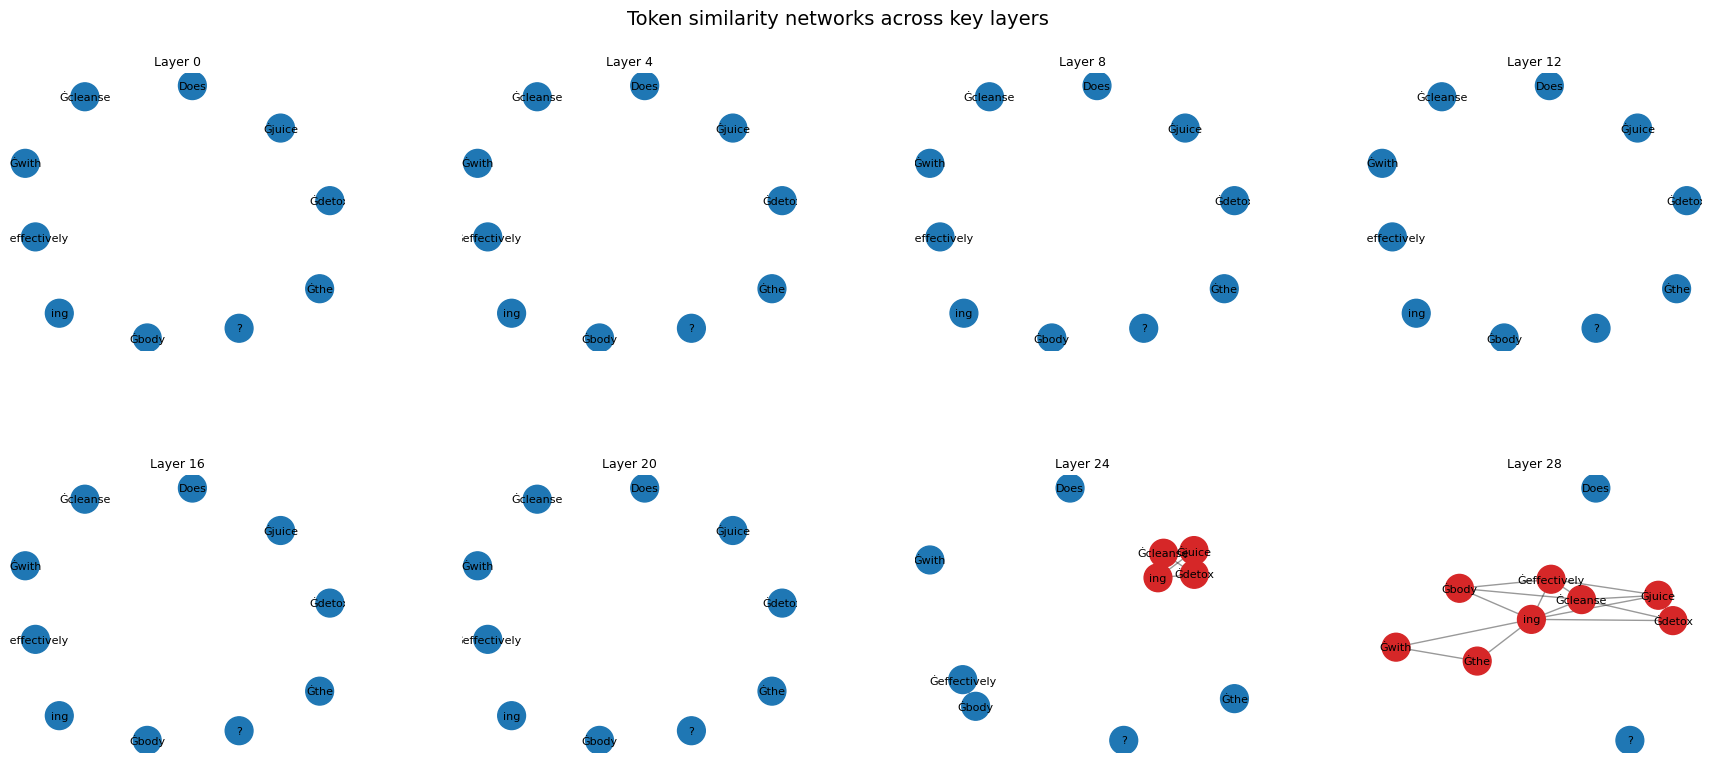

In [55]:
# GPT-2 single-text demo

base_spec = MODEL_SPECS[3]  # gpt2
base_model, base_tokenizer = load_model(base_spec)

example_text = CORPUS[9]
print("Example text:\n", example_text)

demo_single_text_networks(
    base_model,
    base_tokenizer,
    example_text,
    threshold=DEFAULT_THRESHOLD,
    max_length=base_spec["max_length"],
)


In [8]:
# Run all models → compute aggregated stats + critical layers

model_results: Dict[str, Dict[int, Dict[str, float]]] = {}
critical_layers: Dict[str, int | None] = {}

for spec in MODEL_SPECS:
    print(f"\n=== Running model: {spec['id']} ===")
    model, tokenizer = load_model(spec)

    aggregate, all_results = aggregate_over_corpus(
        model,
        tokenizer,
        CORPUS,
        threshold=DEFAULT_THRESHOLD,
        max_length=spec["max_length"],
    )

    model_results[spec['id']] = aggregate

    crit_layer = find_critical_layer(
        aggregate,
        method="max_derivative",
        phi_threshold=0.5
    )
    critical_layers[spec['id']] = crit_layer

    print(f"Critical layer for {spec['id']} (max Δphi): {crit_layer}")



=== Running model: gpt2 ===
Loading model: gpt2 on cpu...


Texts: 100%|██████████| 11/11 [00:00<00:00, 16.33it/s]


Critical layer for gpt2 (max Δphi): 10

=== Running model: qwen1_5 ===
Loading model: Qwen/Qwen1.5-0.5B on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Texts: 100%|██████████| 11/11 [00:01<00:00,  5.69it/s]

Critical layer for qwen1_5 (max Δphi): 22

=== Running model: qwen2_5 ===
Loading model: Qwen/Qwen2.5-0.5B on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Texts: 100%|██████████| 11/11 [00:01<00:00,  6.02it/s]


Critical layer for qwen2_5 (max Δphi): 21

=== Running model: qwen3 ===
Loading model: Qwen/Qwen3-0.6B-base on cpu...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Texts: 100%|██████████| 11/11 [00:02<00:00,  4.96it/s]

Critical layer for qwen3 (max Δphi): 25


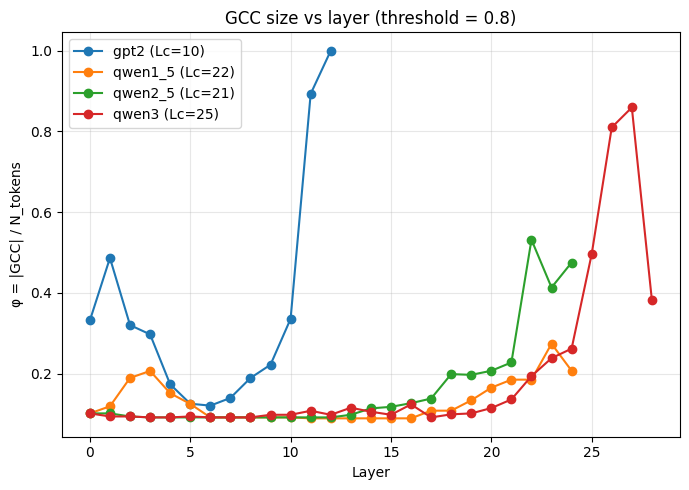

In [32]:
# Plot cross-model GCC (phi) curves

plt.figure(figsize=(7, 5))

for model_id, aggregate in model_results.items():
    layers = sorted(aggregate.keys())
    phi_mean = [aggregate[l]["phi_mean"] for l in layers]

    label = model_id
    if critical_layers[model_id] is not None:
        label += f" (Lc={critical_layers[model_id]})"

    plt.plot(layers, phi_mean, marker="o", label=label)

plt.xlabel("Layer")
plt.ylabel("φ = |GCC| / N_tokens")
plt.title(f"GCC size vs layer (threshold = {DEFAULT_THRESHOLD})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Loading model: Qwen/Qwen3-0.6B-base on cpu...

[Threshold = 0.6] Aggregating over corpus...


Texts: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s]



[Threshold = 0.7] Aggregating over corpus...


Texts: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]



[Threshold = 0.8] Aggregating over corpus...


Texts: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]



[Threshold = 0.9] Aggregating over corpus...


Texts: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


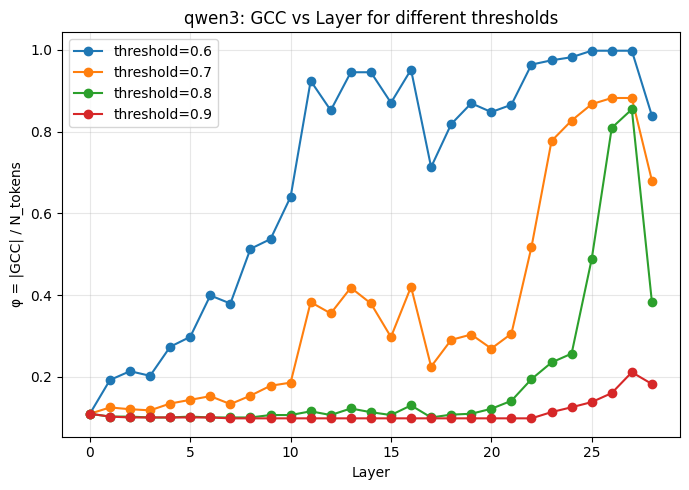

In [59]:
MODEL_ID = "qwen3"   # select "qwen1_5" / "qwen2_5" / "qwen3"
THRESHOLDS = [0.6, 0.7, 0.8, 0.9]

run_threshold_comparison_for_model(
    model_id=MODEL_ID,
    thresholds=THRESHOLDS,
)



Loading model: Qwen/Qwen3-0.6B-base on cpu...


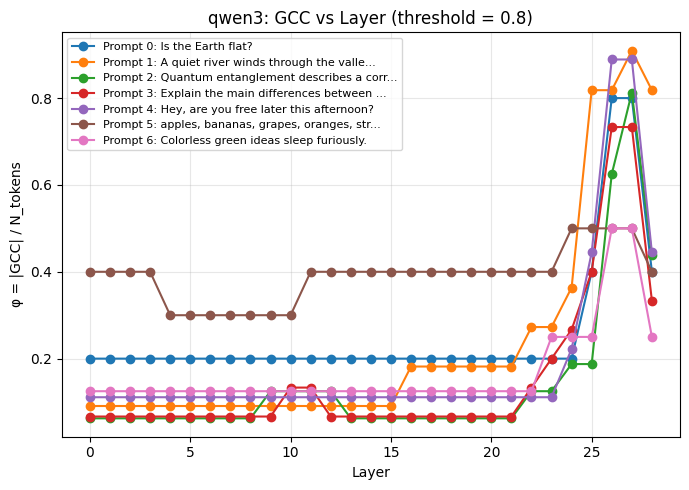

In [71]:
MODEL_ID = "qwen3"
PROMPT_IDXS = [0, 10, 12, 18, 22, 24, 28]
FIXED_THRESHOLD = 0.8

run_prompt_comparison_for_model(
    model_id=MODEL_ID,
    prompt_indices=PROMPT_IDXS,
    threshold=FIXED_THRESHOLD,
)


In [ ]:
inspect_id = "gpt2"

if inspect_id in model_results:
    print(f"\nPer-layer aggregated stats for model: {inspect_id}")
    agg = model_results[inspect_id]

    for l in sorted(agg.keys()):
        s = agg[l]
        print(
            f"Layer {l:2d} | "
            f"phi={s['phi_mean']:.3f}±{s['phi_std']:.3f}, "
            f"#clusters={s['num_clusters_mean']:.2f}±{s['num_clusters_std']:.2f}, "
            f"chi={s['chi_mean']:.2f}±{s['chi_std']:.2f}"
        )
else:
    print(f"Model '{inspect_id}' not found in model_results.")


Per-layer aggregated stats for model: gpt2
Layer  0 | phi=0.332±0.113, #clusters=9.55±3.92, chi=0.91±0.29
Layer  1 | phi=0.486±0.170, #clusters=7.00±3.79, chi=1.08±0.12
Layer  2 | phi=0.320±0.108, #clusters=9.27±4.00, chi=0.94±0.30
Layer  3 | phi=0.297±0.092, #clusters=9.73±4.16, chi=0.96±0.31
Layer  4 | phi=0.173±0.068, #clusters=11.18±4.45, chi=0.68±0.52
Layer  5 | phi=0.125±0.043, #clusters=12.09±5.02, chi=0.38±0.51
Layer  6 | phi=0.121±0.042, #clusters=12.36±5.84, chi=0.38±0.50
Layer  7 | phi=0.140±0.045, #clusters=12.18±5.89, chi=0.56±0.51
Layer  8 | phi=0.189±0.071, #clusters=11.73±6.11, chi=0.83±0.39
Layer  9 | phi=0.222±0.077, #clusters=11.00±6.21, chi=1.01±0.03
Layer 10 | phi=0.336±0.155, #clusters=9.09±5.33, chi=1.08±0.11
Layer 11 | phi=0.893±0.026, #clusters=2.45±1.16, chi=1.02±0.06
Layer 12 | phi=1.000±0.000, #clusters=1.00±0.00, chi=0.00±0.00


In [ ]:
export_model_id = "qwen3"
export_text_idx = len(CORPUS) - 1
export_layer = critical_layers.get(export_model_id, 11) or 11

print(f"Exporting model={export_model_id}, layer={export_layer}")

export_spec = next(s for s in MODEL_SPECS if s["id"] == export_model_id)
model, tokenizer = load_model(export_spec)

hidden_arrays, tokens = extract_hidden_states(
    model,
    tokenizer,
    CORPUS[export_text_idx],
    max_length=export_spec["max_length"],
    device=DEVICE,
)

sim = compute_similarity_matrix(hidden_arrays[export_layer], use_cosine=USE_COSINE)
G_export = build_connectivity_graph(sim, threshold=DEFAULT_THRESHOLD, tokens=tokens)

export_path = os.path.join(
    OUTPUT_DIR,
    f"corpus{export_text_idx}_layer{export_layer}_{export_model_id}.gexf",
)

nx.write_gexf(G_export, export_path)
print(f"Exported Gephi network to: {export_path}")

Exporting model=qwen3, layer=25
Loading model: Qwen/Qwen3-0.6B-base on cpu...
Exported Gephi network to: ./outputs_networks/corpus10_layer25_qwen3.gexf
